In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

C:\Users\alexander.korolyov\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sophius.db import *
from peewee import *
import pandas as pd

query = (Runs
         .select(Runs.id.alias('run_id'), Runs, Models, Devices.name.alias('dev_name'))
         .where(Runs.exp_id==1)
         .join(Models)
         .switch(Runs)
         .join(Devices)
         .dicts())

cols = ['run_id', 'hash', 'flops', 'params', 'val_acc', 'train_acc', 'time', 'dev_name']
df = pd.DataFrame(query)[cols]
df.time = df.time.round()

# df = pd.DataFrame(query)

df

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name
0,1,0080810a080800000049200001000000,2053728,145642,0.663141,0.865986,14.0,NVIDIA GeForce RTX 4090
1,2,00880406200000000024a80001000000,30624,954,0.399900,0.405278,14.0,NVIDIA GeForce RTX 4090
2,3,0080804520000000400000000023300001000000,1437216,29770,0.642238,0.700962,14.0,NVIDIA GeForce RTX 4090
3,4,0080421210080000400000000010000001000000,3738752,7818,0.479167,0.488632,17.0,NVIDIA GeForce RTX 4090
4,5,008402112000000000485000400000000010000001000000,357920,986,0.436639,0.439653,18.0,NVIDIA GeForce RTX 4090
...,...,...,...,...,...,...,...,...
8848,8859,0080442120000000400000000022c80000804412080400...,32131840,959755,0.758193,0.999900,178.0,Quadro RTX 6000
8849,8860,0080482120000000004310004000000000808809100200...,15712800,578090,0.748337,0.999700,121.0,Quadro RTX 6000
8850,8861,0080442120000000400000000080812108040000004890...,424314048,559979,0.745443,0.999800,209.0,Quadro RTX 6000
8851,8862,008800a220000000004320004000000000880822200000...,12173312,424547,0.643339,0.907432,130.0,Quadro RTX 6000


In [3]:
df['len'] = df.hash.apply(len)
df.sort_values(by=['len', 'val_acc'], ascending=[True, False])

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name,len
530,531,008042110804000001000000,3398400,294283,0.644401,0.950270,17.0,NVIDIA GeForce RTX 4090,24
864,865,0080810a0804000001000000,1997952,123467,0.641236,0.885106,15.0,NVIDIA GeForce RTX 4090,24
442,443,0080204a0808000001000000,7341312,260938,0.639073,0.965986,14.0,NVIDIA GeForce RTX 4090,24
1006,1007,008020850804000001000000,2239104,115019,0.636889,0.882021,14.0,NVIDIA GeForce RTX 4090,24
3841,3842,008021110808000001000000,6472704,391114,0.636609,0.974419,15.0,NVIDIA GeForce RTX 4090,24
...,...,...,...,...,...,...,...,...,...
8278,8279,00820061080400004000000000292800008080a1080800...,385514136,1023284,0.737710,0.969852,172.0,NVIDIA GeForce RTX 4090,288
4719,4720,0082010908080000004510004000000000292800008401...,1382664,402453,0.616687,0.694151,79.0,NVIDIA GeForce RTX 4090,296
2186,2187,00841012080400000042a0004000000000810212100400...,1580960,375563,0.540835,0.627955,79.0,NVIDIA GeForce RTX 4090,296
3134,3135,0080281120000000400000000023300000804811080800...,18741728,1270323,0.666747,0.970292,87.0,NVIDIA GeForce RTX 4090,320


In [4]:
from sophius.encode import Encoder

encoder = Encoder()
encoder.hash2model('00802221200000000042a00001000000', (3, 32, 32), 10)

Conv2d       (192, 29, 29)  (4, 4)   (1, 1)  
ReLU         (192, 29, 29) 
MaxPool2d    (192, 15, 15)  (4, 4)   (2, 2)  
Flatten      43200         
Linear       10            

In [5]:
from sophius.modelgen import ConvModelGenerator
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=1, lin_num=1)
t = model_gen.generate_model_tmpl()
print(t)
encoder.model2hash(t)

Conv2d       (192, 10, 10)  (5, 5)   (3, 3)  
LeakyReLU    (192, 10, 10)  (0.001) 
MaxPool2d    (192, 4, 4)    (3, 3)   (2, 2)  
AvgPool2d    (192, 2, 2)    (3, 3)   (1, 1)  
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            



'008021091002000000449000002528000010000001000000'

In [6]:
import torch
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops
from sophius.estimate import Estimator


estimator = Estimator()

In [7]:
from sophius.templates import Conv2dTmpl, ReLUTmpl, GlobalAvgPool2dTmpl, LinearTmpl, ModelTmpl, FlattenTmpl, \
    MaxPool2dTmpl, PReLUTmpl, BatchNorm2dTmpl
from sophius.utils import calc_model_flops

templates = [
    Conv2dTmpl(out_channels=192, kernel_size=(4, 4), stride=(1, 1), padding=False),
    PReLUTmpl(),
    MaxPool2dTmpl(kernel_size=(3, 3), stride=(3, 3), padding=True),
    BatchNorm2dTmpl(),
    FlattenTmpl(),
    LinearTmpl(),
]

t = ModelTmpl((3, 32, 32), 10, *templates)
print(t)
print(calc_model_flops(t.instantiate_model(), t.in_shape))
print('val_acc*', round(estimator.predict_val_acc(t), 3))

Conv2d       (192, 29, 29)  (4, 4)   (1, 1)  
PReLU        (192, 29, 29) 
MaxPool2d    (192, 10, 10)  (3, 3)   (3, 3)  
BatchNorm2d  (192, 10, 10) 
Flatten      19200         
Linear       10            

{'flops': 16408128, 'macs': 7942656, 'params': 201994}
val_acc* 0.657


In [9]:
df['pred_val_acc'] = (df.hash
                      .apply(encoder.hash2model, in_shape=(3, 32, 32), out_shape=10)
                      .apply(estimator.predict_val_acc))

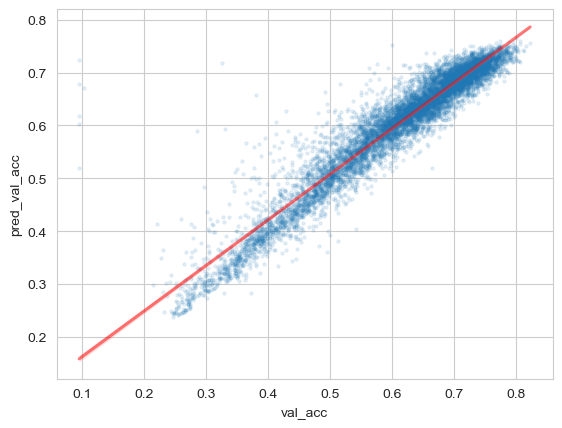

In [10]:
import seaborn as sns

sns.regplot(df, x='val_acc', y='pred_val_acc', scatter_kws={'alpha': 0.1, 's': 5}, line_kws={'color': 'red', 'alpha': 0.5});